# Description - Exploration of NBS Results

This notebook takes the outputs from running NBS and plots then for interpretation

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import os.path as osp
import hvplot.pandas
from utils.basics import FB_400ROI_ATLAS_NAME as ATLAS_NAME
from utils.basics import ATLASES_DIR, RESOURCES_NIMARE_DIR, RESOURCES_CONN_DIR, FB_200ROI_ATLAS_NAME, RESOURCES_NBS_DIR
from utils.plotting import hvplot_fc, hvplot_fc_nwlevel, create_graph_from_matrix, plot_as_graph
import holoviews as hv
from holoviews import opts
from IPython import display
import panel as pn
import matplotlib.pyplot as plt
from nilearn.plotting import plot_connectome
from matplotlib.colors import LinearSegmentedColormap
from sklearn.preprocessing import MinMaxScaler
from nilearn.image import load_img
from nilearn import masking

/data/SFIMJGC_HCP7T/Apps/envs/fc_introspection_2023_py310/lib/python3.10/site-packages/nxviz/__init__.py:18: UserWarning: 
nxviz has a new API! Version 0.7.4 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.4, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)

  warnings.warn(


In [2]:
import os
port_tunnel = int(os.environ['PORT2'])
print('++ INFO: Second Port available: %d' % port_tunnel)

++ INFO: Second Port available: 44769


In [3]:
SOLUTION      = 'CL02'
THRESHOLD     = 'NBS_3p1'
DESIGN_MATRIX = 'SbjAware' #'Basic'
NBS_CONTRASTS = ['Image-Pos-Others_gt_Surr-Neg-Self','Surr-Neg-Self_gt_Image-Pos-Others']

# 2. Load information about the Atlas and ROI needed for plotting

Load the data structure with information about the ROIs in the atlas

In [4]:
ATLASINFO_PATH = osp.join(ATLASES_DIR,ATLAS_NAME,'{ATLAS_NAME}.roi_info.csv'.format(ATLAS_NAME=ATLAS_NAME))
roi_info       = pd.read_csv(ATLASINFO_PATH)
Nrois          = roi_info.shape[0]
print(Nrois)

380


Count the number of networks and get their names

In [5]:
networks = list(roi_info['Network'].unique())
print(networks, len(networks))

['Vis', 'SomMot', 'DorsAttn', 'SalVentAttn', 'Limbic', 'Cont', 'Default', 'Subcortical'] 8


Load the connections that are significantly stronger for the contrast: $$Image-Pos-Others > Surr-Neg-Self$$
and the contrast: $$Surr-Neg-Self > Image-Pos-Others$$

In [6]:
data = {}
for contrast in NBS_CONTRASTS:
    aux_path = osp.join(RESOURCES_NBS_DIR,ATLAS_NAME,f'NBS_{SOLUTION}_Results',THRESHOLD,DESIGN_MATRIX,f'NBS_{SOLUTION}_{contrast}.edge')
    if osp.exists(aux_path):
        aux_data = np.loadtxt(aux_path)
        data[contrast]  = pd.DataFrame(aux_data,
                                         index   = roi_info.set_index(['Hemisphere','Network','ROI_Name','ROI_ID','RGB']).index, 
                                         columns = roi_info.set_index(['Hemisphere','Network','ROI_Name','ROI_ID','RGB']).index)
        print('++ INFO: Data available for %s' % contrast)
    else:
        data[contrast] = pd.DataFrame(np.zeros((Nrois,Nrois)),
                                     index   = roi_info.set_index(['Hemisphere','Network','ROI_Name','ROI_ID','RGB']).index, 
                                     columns = roi_info.set_index(['Hemisphere','Network','ROI_Name','ROI_ID','RGB']).index)
        print('++ WARTNING: No results available for %s' % contrast)

++ WARTNING: No results available for Image-Pos-Others_gt_Surr-Neg-Self
++ INFO: Data available for Surr-Neg-Self_gt_Image-Pos-Others


In [7]:
data['Both'] = data['Image-Pos-Others_gt_Surr-Neg-Self'] - data['Surr-Neg-Self_gt_Image-Pos-Others']

We will also write the results of NBS into text format that we can load into CONN to generate the brain views of the results

In [8]:
for contrast in data.keys():
    if data[contrast] is not None:
        aux_path = osp.join(RESOURCES_CONN_DIR,f'NBS_{DESIGN_MATRIX}_{THRESHOLD}_{contrast}.txt')
        np.savetxt(aux_path,data[contrast].values)
        print("++ INFO: Contrast data [%s] saved to disk %s" %(contrast,aux_path))

++ INFO: Contrast data [Image-Pos-Others_gt_Surr-Neg-Self] saved to disk /data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/conn/NBS_SbjAware_NBS_3p1_Image-Pos-Others_gt_Surr-Neg-Self.txt
++ INFO: Contrast data [Surr-Neg-Self_gt_Image-Pos-Others] saved to disk /data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/conn/NBS_SbjAware_NBS_3p1_Surr-Neg-Self_gt_Image-Pos-Others.txt
++ INFO: Contrast data [Both] saved to disk /data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/conn/NBS_SbjAware_NBS_3p1_Both.txt


# Plot results at the individual connection level

In [9]:
hvplot_fc(data['Both'].loc[:,networks,:].T.loc[:,networks,:].T, by='Network', add_color_segments=True, add_labels=True, cmap=['#4472C4','#ffffff','#ED7D31'], major_label_overrides={-0.5:'Surr-Neg-Self > Images-Pos-Others',0:'',0.5:'Images-Pos-Others > Surr-Neg-Self'}, colorbar_position='top').opts(toolbar=None, title=f'{DESIGN_MATRIX} | {THRESHOLD} | Both')

:Overlay
   .HeatMap.I   :HeatMap   [columns,index]   (value)
   .HLine.I     :HLine   [x,y]
   .VLine.I     :VLine   [x,y]
   .HLine.II    :HLine   [x,y]
   .VLine.II    :VLine   [x,y]
   .HLine.III   :HLine   [x,y]
   .VLine.III   :VLine   [x,y]
   .HLine.IV    :HLine   [x,y]
   .VLine.IV    :VLine   [x,y]
   .HLine.V     :HLine   [x,y]
   .VLine.V     :VLine   [x,y]
   .HLine.VI    :HLine   [x,y]
   .VLine.VI    :VLine   [x,y]
   .HLine.VII   :HLine   [x,y]
   .VLine.VII   :VLine   [x,y]
   .HLine.VIII  :HLine   [x,y]
   .VLine.VIII  :VLine   [x,y]
   .HLine.IX    :HLine   [x,y]
   .VLine.IX    :VLine   [x,y]
   .HLine.X     :HLine   [x,y]
   .VLine.X     :VLine   [x,y]
   .HLine.XI    :HLine   [x,y]
   .VLine.XI    :VLine   [x,y]
   .Segments.I  :Segments   [x0,y0,x1,y1]   (Networks)
   .Segments.II :Segments   [x0,y0,x1,y1]   (Networks)

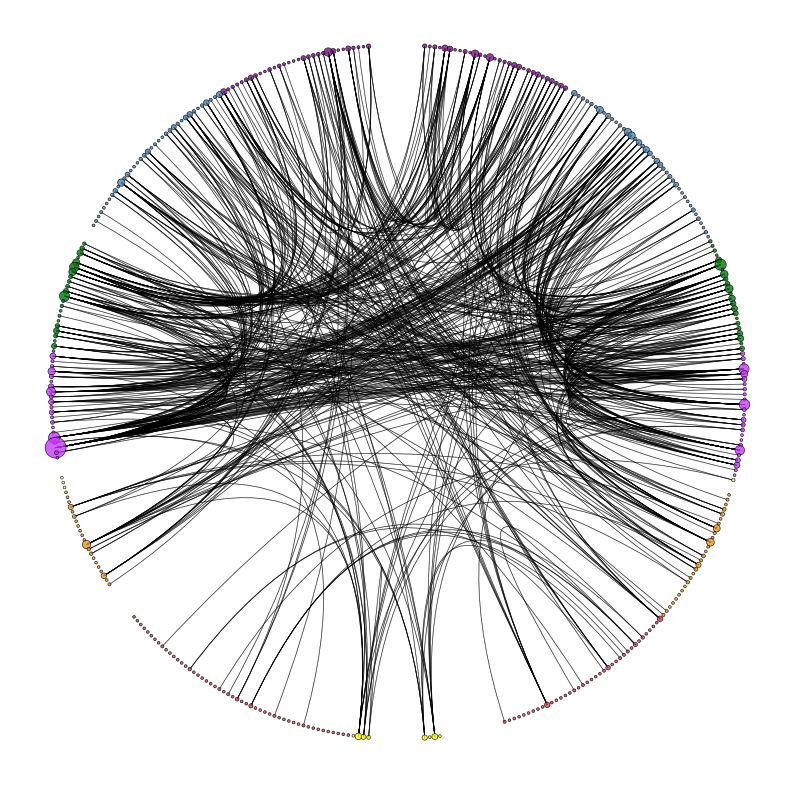

In [10]:
plot_as_graph(data['Surr-Neg-Self_gt_Image-Pos-Others'], edge_weight=.5, show_hemi_labels=False,pos_edges_color='k')

In [11]:
data['Surr-Neg-Self_gt_Image-Pos-Others'].sum(axis=1).sort_values(ascending=False)

Hemisphere  Network      ROI_Name                     ROI_ID  RGB    
LH          SalVentAttn  LH_SalVentAttn_Med_5         111     #c53afd    51.0
                         LH_SalVentAttn_Med_3         109     #c53afb    24.0
RH          DorsAttn     RH_DorsAttn_Post_6           267     #04770c    24.0
            SalVentAttn  RH_SalVentAttn_FrOperIns_3   295     #c93bfc    22.0
                         RH_SalVentAttn_TempOccPar_4  288     #c93afd    21.0
                                                                         ... 
LH          SomMot       LH_SomMot_23                 54      #4682ba     0.0
                         LH_SomMot_22                 53      #4682b9     0.0
RH          SomMot       RH_SomMot_6                  227     #4a81b0     0.0
LH          Cont         LH_Cont_Par_3                119     #e69424     0.0
RH          SomMot       RH_SomMot_35                 256     #4a84b6     0.0
Length: 380, dtype: float64

In [14]:
hvplot_fc_nwlevel(data['Surr-Neg-Self_gt_Image-Pos-Others'], title='', add_net_colors=True, add_net_labels='both', mode='count', cmap='Greys', clim_max=100, labels_text_color='Greys_r').opts(toolbar=None)

:Overlay
   .HeatMap.I   :HeatMap   [columns,index]   (value)
   .Labels.I    :Labels   [x,y]   (NConns)
   .Segments.I  :Segments   [x0,y0,x1,y1]   (Networks)
   .Segments.II :Segments   [x0,y0,x1,y1]   (Networks)

In [13]:
hvplot_fc_nwlevel(data['Image-Pos-Others_gt_Surr-Neg-Self'], title='', add_net_colors=True, add_net_labels='y', mode='count', cmap='Reds', clim_max=30, labels_text_color='Reds_r').opts(toolbar=None)

:Overlay
   .HeatMap.I   :HeatMap   [columns,index]   (value)
   .Labels.I    :Labels   [x,y]   (NConns)
   .Segments.I  :Segments   [x0,y0,x1,y1]   (Networks)
   .Segments.II :Segments   [x0,y0,x1,y1]   (Networks)

# Laterality Index for each contrast


In [ ]:
aux         = (data['Surr-Neg-Self_gt_Image-Pos-Others']).copy()
aux.index   = data['Surr-Neg-Self_gt_Image-Pos-Others'].index.get_level_values('Hemisphere')
aux.columns = data['Surr-Neg-Self_gt_Image-Pos-Others'].columns.get_level_values('Hemisphere')
f2GTf1_LL   = (aux.loc['LH','LH'].sum().sum() / 2)
f2GTf1_RR   = (aux.loc['RH','RH'].sum().sum() / 2)
f2GTf1_LR   = aux.loc['LH','RH'].sum().sum()
print('++ INFO [Surr-Neg-Self > Image-Pos-Others] L-L Conns: %d' % f2GTf1_LL)
print('++ INFO [Surr-Neg-Self > Image-Pos-Others] R-R Conns: %d' % f2GTf1_RR)
print('++ INFO [Surr-Neg-Self > Image-Pos-Others] R-L Conns: %d' % f2GTf1_LR)
print('++ --------------------------------------------------------')
f2GTf1_fcLI  = (f2GTf1_LL - f2GTf1_RR) / (f2GTf1_LL + f2GTf1_RR)
print('++ INFO [Surr-Neg-Self > Image-Pos-Others] fcLI:      %.2f' % f2GTf1_fcLI)

In [16]:
data.keys()

dict_keys(['Image-Pos-Others_gt_Surr-Neg-Self', 'Surr-Neg-Self_gt_Image-Pos-Others', 'Both'])

In [21]:
from statsmodels.stats.multitest import multipletests

In [24]:
multipletests([0.009, 5.6e-5, 0.0000, 0.00],alpha=0.05, method='bonferroni')

(array([ True,  True,  True]),
 array([0.027   , 0.000168, 0.      ]),
 0.016952427508441503,
 0.016666666666666666)